In [1]:
import sys
import os
sys.path.append('..')
os.chdir('..')

import torch
from torch.optim import Adam

from model.loss import Loss
from model.metrics import Accuracy
from utils.util import initModel, timer, SDF

from dataset.data_loaders import getDataloaders
from dataset.data_prepare import generate_sdms, get_tts

import matplotlib.pyplot as plt

from configs import CONF

In [2]:
imIDs = get_tts()
generate_sdms(imIDs)

print(f'[INFO] MODEL: {CONF.MODEL}, DATASET: {CONF.DSET}, LOSS: {CONF.LOSS}')


trainLoader, testLoader = getDataloaders(CONF.DEFAULT_DEVICE, imIDs)
model = initModel(CONF.DEFAULT_DEVICE)
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=CONF.INIT_LR, weight_decay=1e-5)


for epoch in range(CONF.NUM_EPOCHS):
    ts = timer(epoch)
  
    model.train()
    acc = Accuracy('bin')
    lss = Loss(CONF.LOSS)
    for source, gt_mask, gt_sdm in trainLoader:
        source, gt_mask, gt_sdm = source.to(CONF.DEFAULT_DEVICE), gt_mask.to(CONF.DEFAULT_DEVICE), gt_sdm.to(CONF.DEFAULT_DEVICE)

        pred_mask = model(source)
        loss = lss.update(pred_mask, gt_mask, gt_sdm)
        hd95 = acc.update(pred_mask, gt_mask, gt_sdm)
        if torch.isnan(hd95):
           nan_source, nan_gt_mask, nan_gt_sdm, nan_pred_mask = source, gt_mask, gt_sdm, pred_mask


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    trainLoss = lss.compute_avg(trainLoader.__len__())
    trainSegAcc = acc.compute_avg(trainLoader.__len__())

    model.eval()
    acc.reset()
    lss.reset()
    with torch.no_grad():
        for source, gt_mask, gt_sdm in trainLoader:
            source, gt_mask, gt_sdm = source.to(CONF.DEFAULT_DEVICE), gt_mask.to(CONF.DEFAULT_DEVICE), gt_sdm.to(CONF.DEFAULT_DEVICE)

            pred_mask = model(source)
            loss = lss.update(pred_mask, gt_mask, gt_sdm)
            hd95 = acc.update(pred_mask, gt_mask, gt_sdm)
            if torch.isnan(hd95):
                nan_source, nan_gt_mask, nan_gt_sdm, nan_pred_mask = source, gt_mask, gt_sdm, pred_mask

        testLoss = lss.compute_avg(trainLoader.__len__())
        testSegAcc = acc.compute_avg(trainLoader.__len__())


    dt, etc = timer(epoch, ts)
    
    print(f"[{CONF.DEFAULT_DEVICE}] Epoch {epoch + 1}/{CONF.NUM_EPOCHS} | dt: {dt}s :: {etc}m")
    print(f"Train -> loss: {trainLoss:.4f} | DSC: {trainSegAcc['dsc']:.4f} | JCC: {trainSegAcc['iou']:.4f} | HD95: {trainSegAcc['hd95']:.4f} | ASD: {trainSegAcc['asd']:.4f} |")
    print(f"Test  -> loss: {testLoss:.4f} | DSC: {testSegAcc['dsc']:.4f} | JCC: {testSegAcc['iou']:.4f} | HD95: {testSegAcc['hd95']:.4f} | ASD: {testSegAcc['asd']:.4f} |")
    print("--------------------------------------------------------------------------------")

[PROC] SDMs >>> ready
[INFO] MODEL: UNet, DATASET: scarp, LOSS: BinDICE
[INFO] found 694 examples in the training set...
[INFO] found 77 examples in the test set...
--------------------------------------------------------------------------------
[cuda:0] Epoch 1/150 | dt: 20.0s :: 50.0m
Train -> loss: 0.4018 | DSC: 0.6987 | JCC: 0.5509 | HD95: 0.5661 | ASD: 0.2638 |
Test  -> loss: 0.4200 | DSC: 0.6750 | JCC: 0.5136 | HD95: 0.6402 | ASD: 0.2989 |
--------------------------------------------------------------------------------
[cuda:0] Epoch 2/150 | dt: 21.0s :: 52.0m
Train -> loss: 0.2936 | DSC: 0.7966 | JCC: 0.6669 | HD95: 0.7068 | ASD: 0.3419 |
Test  -> loss: 0.2532 | DSC: 0.8129 | JCC: 0.6897 | HD95: 0.7709 | ASD: 0.3810 |
--------------------------------------------------------------------------------
[cuda:0] Epoch 3/150 | dt: 21.0s :: 51.0m
Train -> loss: 0.2630 | DSC: 0.8145 | JCC: 0.6937 | HD95: 0.7574 | ASD: 0.3715 |
Test  -> loss: 0.2347 | DSC: 0.8273 | JCC: 0.7106 | HD95: 0.7

KeyboardInterrupt: 

In [10]:
nan_pred_mask.device

device(type='cuda', index=0)

In [11]:
# nan_source, nan_gt_mask, nan_gt_sdm, nan_pred_mask

nan_pred_mask = torch.relu(torch.sign(torch.sigmoid(nan_pred_mask)-0.5))
nan_pred_sdm = SDF(nan_pred_mask, kernel_size = 7)

dP = torch.abs(torch.multiply(nan_gt_sdm, nan_pred_mask))
dP = torch.where(dP == 0, float('nan'), dP)
dG = torch.abs(torch.multiply(nan_pred_sdm, nan_gt_mask))
dG = torch.where(dG == 0, float('nan'), dG)


dPdG = torch.cat((dP, dG), dim=0).view(dP.shape[0]*2, 1, -1)
HD95 = torch.mean(torch.nanquantile(dPdG, 0.95, dim=2))

In [16]:
torch.nanmean(torch.nanquantile(dPdG, 0.95, dim=2))

tensor(0.7528, device='cuda:0')

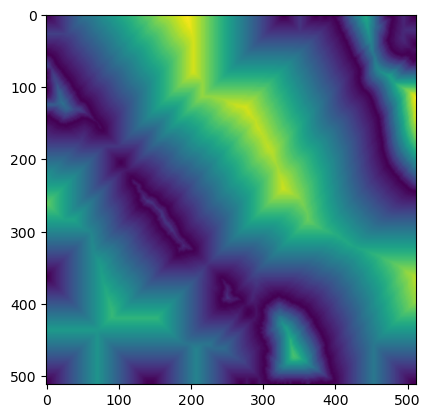

In [23]:
nan_pred_mask = torch.relu(torch.sign(torch.sigmoid(nan_pred_mask)-0.5))
nan_pred_sdm = SDF(nan_pred_mask, kernel_size = 7)

plt.imshow(torch.abs(nan_pred_sdm[4][0]).cpu().detach().numpy(), cmap ='viridis')

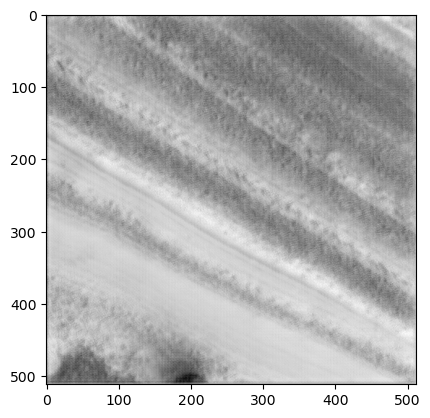

In [3]:
plt.imshow(nan_pred_mask[3][0].cpu().detach().numpy(), cmap ='gray')

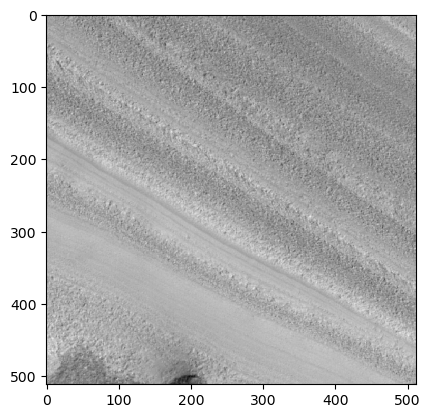

In [4]:
plt.imshow(nan_source[3][0].cpu().detach().numpy(), cmap ='gray')

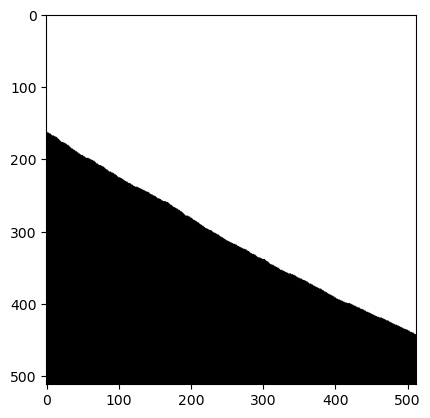

In [5]:
plt.imshow(nan_gt_mask[3][0].cpu().detach().numpy(), cmap ='gray')